# importing matplotlib for plotting at the bottom of this notebook

In [1]:
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime #added for Windows users
current_time = datetime.now() #added for Windows users
#!date #did not work on Windows
print(current_time.strftime('%m/%d/%Y %H:%M'))
!whoami

01/05/2020 18:01
root


# load in all functions from `route_shape_process_scripts.py` file

In [3]:
import route_shape_process_scripts as f1

# General transformation flow in this notebook:
- import gtfs files
- pick a route of interest
- grab position files for all routes
- filter positions for only that route
- add time index (this is used to break up positions by datetime and join with gtfs)
- get popular shape in both route directions (direction_id)
- make a route_vertex geopandas dataframe - we'll use this to find "nearest" route node
- take all positions and find closest route node
- append route info (distance traveled / shape_pt_sequence)
- create timing metrics based on `trip_start_time` and `time_pct` <- position observation time - converted to Pacific

# import gtfs from 01_gtfs_transform notebook output

In [4]:
#if you ran notebook 01_gtfs this path should be correct
gtfs_merge_file_path = "./data/gtfs_merge/"
agg_filename = [f for f in listdir(gtfs_merge_file_path) if isfile(join(gtfs_merge_file_path, f)) 
                and 'agg' in f][0]
routes_filename = [f for f in listdir(gtfs_merge_file_path) if isfile(join(gtfs_merge_file_path, f)) 
                and 'routes' in f][0]
shapes_filename = [f for f in listdir(gtfs_merge_file_path) if isfile(join(gtfs_merge_file_path, f)) 
                and 'shapes' in f][0]
trips_filename = [f for f in listdir(gtfs_merge_file_path) if isfile(join(gtfs_merge_file_path, f)) 
                and 'trips' in f][0]

In [5]:
full_routes_gtfs = pd.read_csv(f"{gtfs_merge_file_path}{routes_filename}", low_memory=False)
full_shapes_gtfs = pd.read_csv(f"{gtfs_merge_file_path}{shapes_filename}", low_memory=False)
full_trips_gtfs = pd.read_csv(f"{gtfs_merge_file_path}{trips_filename}", low_memory=False)
full_trip_stop_schedule = pd.read_csv(f"{gtfs_merge_file_path}{agg_filename}", low_memory=False)

In [6]:
tripid_w_starttime = full_trip_stop_schedule.groupby('trip_id')\
                        .agg({'trip_start_time':'min'})\
                        .reset_index()

# break up the gtfs by `start date` and `end date`. TODO: there is a better way to do this. Right now, we want to make sure the vehicle position observation is joined with the `right` gtfs information. The simplest way to do that is to break up the position file by date and break up the gtfs by date and only join where the date windows match. 

In [7]:
full_trip_stop_schedule_dict = {}
for name, group in full_trip_stop_schedule.groupby(['start_gtfs_date','end_gtfs_date']):
    full_trip_stop_schedule_dict[name] = group

## get route name -- id dictionary. Nathaniel has a better class for this in `/data_transformations` but I haven't incorporated it yet. the below dictionary works as a quick/dirty way to input `route_short_name` and output `route_id`

In [8]:
route_name_to_id_dict = dict(zip(full_routes_gtfs.route_short_name.tolist(),
                                 full_routes_gtfs.route_id.tolist()))

In [9]:
route_id_to_name_dict = dict(zip(full_routes_gtfs.route_id.tolist(),
                                 full_routes_gtfs.route_short_name.tolist()))

In [10]:
route_id_to_name_dict[100002]

'10'

## select a route

In [11]:
#get_select_routeid_name(full_routes_gtfs, ['E Line'])[2]
route_of_interest = '8'
route_of_interest_id = route_name_to_id_dict[route_of_interest]
route_of_interest_id

100275

# get all position files for these months

In [12]:
position_file_location = "./data/intermed/"
position_date = "201905"
# month_list = ['201809', '201810', '201811']
# full_route_positions = get_positions_months(month_list, position_file_location)
full_route_positions = pd.read_hdf(f"{position_file_location}positions_{position_date}.h5",low_memory=False)

# take only the positions for the choosen route_id

In [13]:
single_route_positions = full_route_positions[
                        full_route_positions['route_id']==route_of_interest_id].copy()

# make sure the route dataframe is not empty

In [14]:
single_route_positions.empty

False

# add time index columns

In [15]:
#single_route_positions = f1.convert_index_to_pct(single_route_positions)
single_route_positions = f1.add_time_index_columns(single_route_positions)

# find the most popular shape on that route id going in one direction

In [16]:
direction = 1
shape_of_interest_id, trip_headsign = f1.get_most_used_shape_id_per_direction(full_trip_stop_schedule, 
                                                                           route_of_interest_id, 
                                                                           direction)

# make one route_vertex_geo from shape_id

In [17]:
route_vertex_geo = f1.make_geopandas_shape_df(full_shapes_gtfs, shape_of_interest_id)

# join position table with trip gtfs information

In [18]:
positions_w_trips = {}
for name, group in full_trips_gtfs.groupby(['start_gtfs_date','end_gtfs_date']):
    print(name)
    positions_w_trips[name] = f1.join_positions_with_gtfs_trips(single_route_positions, group, name[0], name[1])

('2019-04-20', '2019-05-08')
('2019-05-09', '2019-06-18')


# merge all dictionaries into one

In [19]:
for idx, dict_group in enumerate(positions_w_trips.keys()):
    print(dict_group)
    if positions_w_trips[dict_group].empty:
        pass
    else:
        if idx == 0:
            unpacked_positions_full = positions_w_trips[dict_group].copy()
        else:
            unpacked_positions_full = unpacked_positions_full.append(positions_w_trips[dict_group])

('2019-04-20', '2019-05-08')
('2019-05-09', '2019-06-18')


# only take positions along one `shape_id`

In [20]:
unpacked_positions_one_shape = unpacked_positions_full[unpacked_positions_full['shape_id']==shape_of_interest_id]

In [21]:
unpacked_positions_one_shape.head()

,route_id,timestamp,trip_id,vehicle_id,vehicle_lat,vehicle_long,time_utc,time_pct,day,year,month,hour,dow,direction_id,shape_id,month_day_trip_veh
1,100275,1556668584,43238248,8229,47.585213,-122.298134,2019-04-30 23:56:24,2019-04-30 16:56:24-07:00,30,2019,4,16,1,1,40008003,2019_4_30_43238248_8229
2,100275,1556668716,43238249,8077,47.616241,-122.296158,2019-04-30 23:58:36,2019-04-30 16:58:36-07:00,30,2019,4,16,1,1,40008003,2019_4_30_43238249_8077
4,100275,1556668729,43238251,8028,47.618496,-122.330879,2019-04-30 23:58:49,2019-04-30 16:58:49-07:00,30,2019,4,16,1,1,40008003,2019_4_30_43238251_8028
6,100275,1556668746,43238267,8204,47.618534,-122.338219,2019-04-30 23:59:06,2019-04-30 16:59:06-07:00,30,2019,4,16,1,1,40008003,2019_4_30_43238267_8204
10,100275,1556668793,43238252,8203,47.621834,-122.356720,2019-04-30 23:59:53,2019-04-30 16:59:53-07:00,30,2019,4,16,1,1,40008003,2019_4_30_43238252_8203


# try parallel below - I don't think the parallel function will work on a Windows computer (I've had trouble in the past). It should work fine on a Mac.

### the below takes ~1-2 minutes on my computer depending on the shape/number of trips

In [22]:
if __name__ == "__main__":
    start = time.time()
    positions_w_near_node_df = f1.get_close_node_process(unpacked_positions_one_shape, route_vertex_geo)
    end = time.time()
    print(end - start)

43.26791954040527


# convert `time_pct` to Pacific time for datetime tranforms below

In [23]:
positions_w_near_node_datetime = f1.datetime_transform_df(positions_w_near_node_df)

In [85]:
position_w_node_schedule = f1.join_tripstart(positions_w_near_node_datetime, 
                                                            full_trip_stop_schedule, 
                                                            tripid_w_starttime)

In [86]:
position_w_node_schedule['distance_btw_veh_and_shape'] = position_w_node_schedule\
                                                                .apply(lambda x: f1.calc_distance(x['vehicle_lat'],
                                                                x['vehicle_long'], 
                                                                x['shape_pt_lat'],
                                                               x['shape_pt_lon']), axis=1)

## add in Nathaniel's code for finding closest point on route

In [477]:
import find_closest_route_point as f2

In [407]:
position_w_node_schedule.iloc[0]

level_0                                                        0
route_id                                                  100275
timestamp                                             1556668584
trip_id                                                 43238248
vehicle_id                                                  8229
vehicle_lat                                              47.5852
vehicle_long                                            -122.298
time_utc                                     2019-04-30 23:56:24
time_pct                               2019-04-30 16:56:24-07:00
day                                                           30
year                                                        2019
month                                                          4
hour                                                          16
dow                                                            1
direction_id                                                   1
shape_id                 

In [409]:
position_w_node_schedule.drop(['index'], axis=1,inplace=True)

In [410]:
import numpy as np

In [496]:
if __name__ == "__main__":
    start = time.time()
    position_w_closest_df = f2.get_closeset_point_process(position_w_node_schedule, full_shapes_gtfs, shape_of_interest_id)
    end = time.time()
    print(end - start)

223.16699767112732


## unpack the tuple

In [497]:
position_w_closest_df['closest_pt_coords'] = position_w_closest_df['closest_pt_on_route_tuple'].apply(lambda x: x[0])
position_w_closest_df['shape_dist_traveled_to_closest_pt'] = position_w_closest_df['closest_pt_on_route_tuple'].apply(lambda x: x[1])

In [498]:
position_w_closest_df.drop(['closest_pt_on_route_tuple'], axis=1,inplace=True)

In [499]:
position_w_closest_df.iloc[0]

route_id                                                                 100275
timestamp                                                            1556668584
trip_id                                                                43238248
vehicle_id                                                                 8229
vehicle_lat                                                             47.5852
vehicle_long                                                           -122.298
time_utc                                                    2019-04-30 23:56:24
time_pct                                              2019-04-30 16:56:24-07:00
day                                                                          30
year                                                                       2019
month                                                                         4
hour                                                                         16
dow                                     

# below is an interactive graph if you installed `ipywidgets`

# importing interactive libraries for interactive plots at the bottom of this notebook, you can comment these out if you just want to do transformations

In [500]:
#comment out these libraries if you don't want/have interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# look at one unique trip

# compare `shape_dist_traveled_to_closest_pt` vs. `shape_dist_traveled`

In [501]:
@interact
def show_one_unique_trip(x=list(position_w_closest_df['month_day_trip_veh'].unique())):
    onetrip_df = position_w_closest_df[
    position_w_closest_df['month_day_trip_veh']==x][
                                                                    ['month_day_trip_veh',
                                                                     'trip_id',
                                                                     'route_id',
                                                                     'stop_name',
                                                                     'shape_pt_sequence',
                                                                     'shape_dist_traveled',
                                                                     'shape_dist_traveled_to_closest_pt',
                                                                     'time_pct',
                                                                    'trip_start_time',
                                                                    'arrival_time',
                                                                     'actual_time_from_scheduled_start',
                                                                     'scheduled_time_from_scheduled_start'
                                                                    ]]

    x = onetrip_df['shape_dist_traveled_to_closest_pt'].values
    x2 = onetrip_df['shape_dist_traveled'].values
    y1 = onetrip_df['actual_time_from_scheduled_start'].values
#     y2 = onetrip_df['scheduled_time_from_scheduled_start'].values

    x_labels = onetrip_df['stop_name'].values
    fig, ax = plt.subplots(figsize=(15,7))
    ax.scatter(x, y1, label='closest_projected_pt', color='red')
    ax.scatter(x2, y1, label='closest_route_vertex', color='blue')
#     ax.scatter(x, y2, label='sched_time', color='blue')
    ax.set_xlabel("distance traveled (m)")
    ax.set_ylabel("time from start (min)")
    _ = ax.legend()

interactive(children=(Dropdown(description='x', options=('2019_4_30_43238248_8229', '2019_4_30_43238249_8077',…

In [526]:
@interact
def show_one_unique_trip(x=list(position_w_closest_df['trip_id'].unique())):
    onetrip_df = position_w_closest_df[
    position_w_closest_df['trip_id']==x][
                                                                    ['month_day_trip_veh',
                                                                     'trip_id',
                                                                     'route_id',
                                                                     'stop_name',
                                                                     'shape_pt_sequence',
                                                                     'shape_dist_traveled',
                                                                     'shape_dist_traveled_to_closest_pt',
                                                                     'time_pct',
                                                                    'trip_start_time',
                                                                    'arrival_time',
                                                                     'actual_time_from_scheduled_start',
                                                                     'scheduled_time_from_scheduled_start'
                                                                    ]]

    x = onetrip_df['shape_dist_traveled_to_closest_pt'].values
    x2 = onetrip_df['shape_dist_traveled'].values
    y1 = onetrip_df['actual_time_from_scheduled_start'].values
#     y2 = onetrip_df['scheduled_time_from_scheduled_start'].values

    x_labels = onetrip_df['stop_name'].values
    fig, ax = plt.subplots(figsize=(15,7))
    ax.scatter(x, y1, label='closest_projected_pt', color='red', alpha=0.4)
    ax.scatter(x2, y1, label='closest_route_vertex', color='blue', alpha=0.4)
#     ax.scatter(x, y2, label='sched_time', color='blue')
    ax.set_xlabel("distance traveled (m)")
    ax.set_ylabel("time from start (min)")
    _ = ax.legend()

interactive(children=(Dropdown(description='x', options=(43238248, 43238249, 43238251, 43238252, 43238267, 432…

## It's good to check if our distances are significantly different using the closest distance on the route vs. the nearest route vertex's shape_dist_traveled

### First create a field of the difference between the two measurements

In [502]:
position_w_closest_df['diff_shape_distance_traveled'] = position_w_closest_df.apply(lambda x:
                                                                                         (x.shape_dist_traveled-
                                                                                         x.shape_dist_traveled_to_closest_pt),
                                                                                         axis=1)

### Second make a histogram of `diff_shape_distance_traveled` and see what it looks like

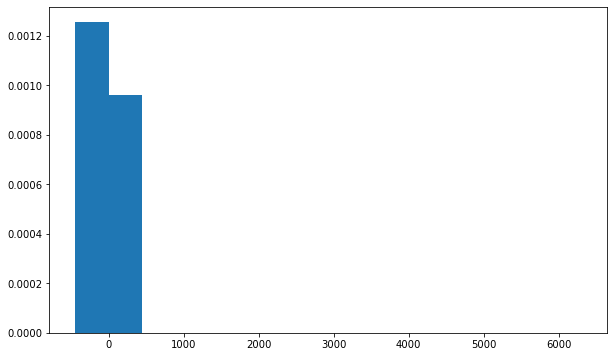

In [503]:
fig, ax = plt.subplots(figsize=(10,6))
_ = ax.hist(position_w_closest_df['diff_shape_distance_traveled'].values, bins=15, density=True)

# looks like there are a lot of small outliers

In [504]:
position_w_closest_df['diff_shape_distance_traveled'].describe()

count    53970.000000
mean        -2.844178
std         38.513674
min       -453.652012
25%         -7.643748
50%         -3.800306
75%         -0.079497
max       6312.300160
Name: diff_shape_distance_traveled, dtype: float64

### from the histogram and summary statistics we can see the standard deviation

### My first guess was that some of this variance could be coming from bad vehicle location points. To investigate that option, we can look at distance from vehicle to shape distribution

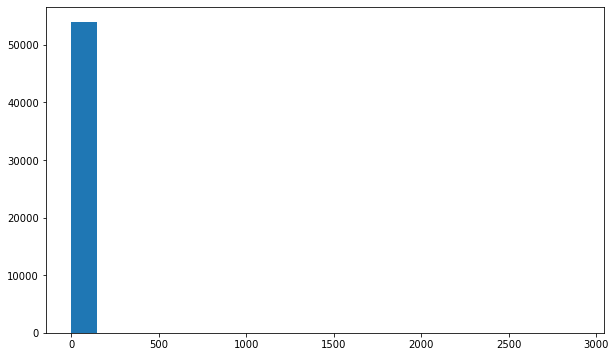

In [505]:
fig, ax = plt.subplots(figsize=(10,6))
_ = ax.hist(position_w_closest_df['distance_btw_veh_and_shape'].values, bins=20)

In [506]:
position_w_closest_df['distance_btw_veh_and_shape'].describe()

count    53970.000000
mean         3.996731
std         24.385258
min          0.002639
25%          0.594054
50%          1.277702
75%          2.617101
max       2899.720833
Name: distance_btw_veh_and_shape, dtype: float64

### look at the standard deviation for the distance between vehicle and shape and use that to filter below

In [507]:
veh_dist_to_shape_std_dev = position_w_closest_df['distance_btw_veh_and_shape'].describe()['std']
len(position_w_closest_df[position_w_closest_df['distance_btw_veh_and_shape']>veh_dist_to_shape_std_dev])

1793

In [508]:
position_w_closest_df[position_w_closest_df['distance_btw_veh_and_shape']>veh_dist_to_shape_std_dev][
                                                                    ['month_day_trip_veh',
                                                                     'trip_id',
                                                                     'hour',
                                                                     'dow',
                                                                     'route_id',
                                                                     'stop_name',
                                                                     'shape_pt_sequence',
                                                                     'distance_btw_veh_and_shape',
                                                                     'shape_dist_traveled',
                                                                     'shape_dist_traveled_to_closest_pt',
                                                                     'actual_time_from_scheduled_start'
                                                                    ]].head(3)

,month_day_trip_veh,trip_id,hour,dow,route_id,stop_name,shape_pt_sequence,distance_btw_veh_and_shape,shape_dist_traveled,shape_dist_traveled_to_closest_pt,actual_time_from_scheduled_start
0,2019_4_30_43238248_8229,43238248,16,1,100275,NaN,240,29.688211,34266.6,34364.386600,50.400000
33,2019_4_30_43238249_8077,43238249,17,1,100275,NaN,206,32.648103,31858.4,31750.157898,54.450000
63,2019_4_30_43238267_8204,43238267,17,1,100275,Martin L King Jr Way E & E John St,137,70.846631,19483.1,19715.308209,41.483333


## Let's inspect the vehicle points far from the route shape vertex in a map below. I like using Carto's basemaps (they're free! and I think less glitchy than Leaflet plugin). In order to run the cells below you'll need to install the following:
- `pip install carto`
- `pip install cartoframes==1.0b6`

In [509]:
from cartoframes.viz import Map, Layer, basemaps, Popup
from cartoframes.viz.helpers import color_continuous_layer, color_bins_layer, utils
from matplotlib import cm
from cartoframes.data import dataset

## plot far vehicles

In [510]:
far_vehicles = position_w_closest_df[position_w_closest_df['distance_btw_veh_and_shape']>veh_dist_to_shape_std_dev]

###############################################
## vehicle points ############################
###############################################

vehicle_pt_df = far_vehicles[['shape_pt_sequence','vehicle_lat','vehicle_long']].copy()
geometry = vehicle_pt_df.apply(lambda x: Point(x.vehicle_long, x.vehicle_lat), axis=1)
vehicle_pt_geo = gpd.GeoDataFrame(vehicle_pt_df, crs={'init':'4326'},geometry=geometry.tolist())

###############################################
## route vertex points ####### route_vertex_geo
###############################################

display(Map(

    [Layer(route_vertex_geo,
          'color: black',
           popup=Popup({
        'hover': {
            'title': 'shape_pt_sequence',
            'value': '$shape_pt_sequence'
        }
    })
         ),
     Layer(vehicle_pt_geo,
           'color: blue',
           popup=Popup({
        'hover': {
            'title': 'shape_pt_sequence',
            'value': '$shape_pt_sequence'
        }
    })
         )
    ]
))

# From the map above, it looks like the vehicle location is far from a route_vertex when 
- there are significant gaps in the route vertices (long straight roads in the route)
- and the vehicle is off the route

## let's try plotting the vehicle point projected on the route vs. the nearest route vertex for these cases. This is when Nathaniel's method shines :)

In [511]:
far_vehicles = position_w_closest_df[position_w_closest_df['distance_btw_veh_and_shape']>veh_dist_to_shape_std_dev]

###############################################
## closest points ############################
###############################################

closest_pt_df = far_vehicles[['time_pct','closest_pt_coords',
                                  'shape_dist_traveled_to_closest_pt',
                                  'actual_time_from_scheduled_start']].copy()
closest_pt_df['geometry'] = closest_pt_df['closest_pt_coords'].apply(lambda x: Point(x))
closest_pt_df['time_pct_str'] = closest_pt_df['time_pct'].apply(lambda x: x.strftime("%H:%M:%S"))
closest_pt_df.drop(['time_pct','closest_pt_coords'], axis=1, inplace=True)
closest_pt_geo = gpd.GeoDataFrame(closest_pt_df, crs={'init':'4326'},geometry='geometry')

###############################################
## vehicle points ############################
###############################################

vehicle_pt_df = far_vehicles[['time_pct','vehicle_lat','vehicle_long','shape_dist_traveled',
                                      'shape_pt_sequence','distance_btw_veh_and_shape',
                                      'actual_time_from_scheduled_start']].copy()
vehicle_pt_df['time_pct_str'] = vehicle_pt_df['time_pct'].apply(lambda x: x.strftime("%H:%M:%S"))
vehicle_pt_df.drop(['time_pct'], axis=1, inplace=True)
vehicle_pt_df['geometry'] = vehicle_pt_df.apply(lambda x: Point(x.vehicle_long, x.vehicle_lat), axis=1)
vehicle_pt_geo = gpd.GeoDataFrame(vehicle_pt_df, crs={'init':'4326'},geometry='geometry')

###############################################
## route vertex points ####### route_vertex_geo
###############################################

display(Map(

    [Layer(route_vertex_geo,
          'color: black',
           popup=Popup({
        'click': {
            'title': 'shape_pt_sequence',
            'value': '$shape_pt_sequence'
        }
    })
         ),
     Layer(vehicle_pt_geo,
           'color: blue',
           popup=Popup({
        'hover': {
            'title': 'shape_pt_sequence',
            'value': '$shape_pt_sequence'
        }
    })
         ),
     Layer(closest_pt_geo,
           'color: red',
           popup=Popup({
        'hover': {
            'title': 'shape_dist_traveled_to_closest_pt',
            'value': '$shape_dist_traveled_to_closest_pt'
        }
    })
         )

    ]
))

# in the map above, you can see the red points hugging the route shape. 
- this works when there are gaps in the route 
- this _does not work_ when the bus goes off the route

In [512]:
far_vehicles.loc[:,"vehicle_shape_pt_hour"] = (far_vehicles.loc[:,['vehicle_id','shape_pt_sequence','hour']]
                                               .apply(lambda x: str(x['vehicle_id'])
                                                                +"_"+
                                                                 str(x['shape_pt_sequence'])
                                                                +"_"+
                                                                str(x['hour']),
                                                     axis=1).copy())


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [513]:
@interact
def show_one_unique_trip(x=list(far_vehicles['vehicle_shape_pt_hour'].unique())):
    ###############################################
    ## closest points ############################
    ###############################################
    
    specific_far_vehicle = far_vehicles[far_vehicles['vehicle_shape_pt_hour']==x].copy()
    
    shape_pt_sequence = specific_far_vehicle['shape_pt_sequence'].values[0]

    closest_pt_df = specific_far_vehicle[['time_pct','closest_pt_coords',
                                      'shape_dist_traveled_to_closest_pt',
                                      'actual_time_from_scheduled_start']].copy()
    closest_pt_df['geometry'] = closest_pt_df['closest_pt_coords'].apply(lambda x: Point(x))
    closest_pt_df['time_pct_str'] = closest_pt_df['time_pct'].apply(lambda x: x.strftime("%H:%M:%S"))
    closest_pt_df.drop(['time_pct','closest_pt_coords'], axis=1, inplace=True)
    closest_pt_geo = gpd.GeoDataFrame(closest_pt_df, crs={'init':'4326'},geometry='geometry')

    ###############################################
    ## vehicle points ############################
    ###############################################

    vehicle_pt_df = specific_far_vehicle[['time_pct','vehicle_lat','vehicle_long','shape_dist_traveled',
                                          'shape_pt_sequence','distance_btw_veh_and_shape',
                                          'actual_time_from_scheduled_start']].copy()
    vehicle_pt_df['time_pct_str'] = vehicle_pt_df['time_pct'].apply(lambda x: x.strftime("%H:%M:%S"))
    vehicle_pt_df.drop(['time_pct'], axis=1, inplace=True)
    vehicle_pt_df['geometry'] = vehicle_pt_df.apply(lambda x: Point(x.vehicle_long, x.vehicle_lat), axis=1)
    vehicle_pt_geo = gpd.GeoDataFrame(vehicle_pt_df, crs={'init':'4326'},geometry='geometry')
    
#     adjacent_pt_data = f2.get_adjacent_shape_point_data(full_shapes_gtfs, shape_pt_sequence, 
#                                                         use_index=False, use_shape_pt_sequence=True)
#     adjacent_list = adjacent_pt_data['shape_pt_sequence'].tolist()
#     adjacent_list.append(shape_pt_sequence_of_interest)
#     route_pts = route_vertex_geo[route_vertex_geo['shape_pt_sequence'].isin(adjacent_list)]

    
    display(Map(

    [Layer(route_vertex_geo,
          'color: black',
           popup=Popup({
        'hover': {
            
            'title':'shape_dist_traveled',
            'value': '$shape_dist_traveled'
        }
    })
         ),
     Layer(vehicle_pt_geo,
           'color: blue',
           popup=Popup({
        'hover': {
            'title': 'shape_pt_sequence',
            'value': '$shape_pt_sequence'
        }
    })
         ),
     Layer(closest_pt_geo,
           'color: red',
           popup=Popup({
        'hover': {
            'title': 'shape_dist_traveled_to_closest_pt',
            'value': '$shape_dist_traveled_to_closest_pt'
        }
    })
         )

    ]
))

interactive(children=(Dropdown(description='x', options=('8229_240_16', '8077_206_17', '8204_137_17', '8227_7_…

# let's remove 
- if  it is the first or last shape point, only take vehicle observations  with `distance_btw_veh_and_shape` that are < 1 std dev
- if it is not a first/last shape point, take vehicle observations, that are 2*`distance_btw_veh_and_shape` std dev

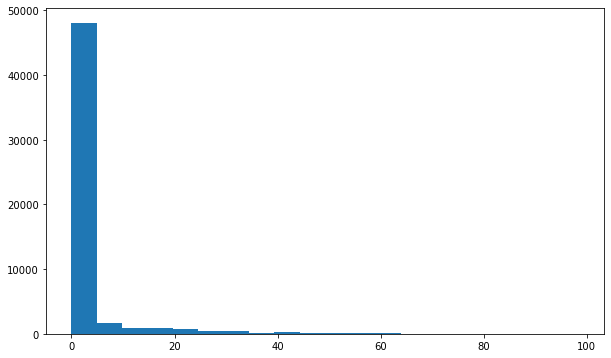

In [551]:
filtered_position_w_node_schedule = position_w_closest_df[position_w_closest_df['distance_btw_veh_and_shape']
                                                          <100].copy()

fig, ax = plt.subplots(figsize=(10,6))
_ = ax.hist(filtered_position_w_node_schedule['distance_btw_veh_and_shape'].values, bins=20)

# plot all again after filter

In [552]:
###############################################
## closest points ############################
###############################################

closest_pt_df = filtered_position_w_node_schedule[['time_pct','closest_pt_coords','shape_pt_sequence',
                                  'shape_dist_traveled_to_closest_pt','month_day_trip_veh',
                                  'actual_time_from_scheduled_start']].copy()
closest_pt_df['geometry'] = closest_pt_df['closest_pt_coords'].apply(lambda x: Point(x))
closest_pt_df['time_pct_str'] = closest_pt_df['time_pct'].apply(lambda x: x.strftime("%H:%M:%S"))
closest_pt_df.drop(['time_pct','closest_pt_coords'], axis=1, inplace=True)
closest_pt_geo = gpd.GeoDataFrame(closest_pt_df, crs={'init':'4326'},geometry='geometry')

###############################################
## vehicle points ############################
###############################################

vehicle_pt_df = filtered_position_w_node_schedule[['time_pct','vehicle_lat','vehicle_long','shape_dist_traveled',
                                      'shape_pt_sequence','distance_btw_veh_and_shape','month_day_trip_veh',
                                      'actual_time_from_scheduled_start']].copy()
vehicle_pt_df['time_pct_str'] = vehicle_pt_df['time_pct'].apply(lambda x: x.strftime("%H:%M:%S"))
vehicle_pt_df.drop(['time_pct'], axis=1, inplace=True)
vehicle_pt_df['geometry'] = vehicle_pt_df.apply(lambda x: Point(x.vehicle_long, x.vehicle_lat), axis=1)
vehicle_pt_geo = gpd.GeoDataFrame(vehicle_pt_df, crs={'init':'4326'},geometry='geometry')

###############################################
## route vertex points ####### route_vertex_geo
###############################################

display(Map(

    [Layer(route_vertex_geo,
          'color: black',
           popup=Popup({
        'click': {
            'title': 'shape_pt_sequence',
            'value': '$shape_pt_sequence'
        }
    })
         ),
     Layer(vehicle_pt_geo,
           'color: blue',
           popup=Popup({
        'click': {
            'title': 'month_day_trip_veh',
            'value': '$month_day_trip_veh'
        }
    })
         ),
     Layer(closest_pt_geo,
           'color: red',
           popup=Popup({
        'click': {
            'title': 'month_day_trip_veh',
            'value': '$month_day_trip_veh'
        }
    })
         )

    ]
))